# GPS to XY: Team Visualization

#### This script converts the STATSports GPS data export into cartesian coordinates (x,y) and exports a video (.mp4) in cartesian coordinates. 

#### The script also calculates the area occupied by the team, the centre of mass and the convex hull vertices.

Note: Create a folder for each half (~45min) with the data export for each player. This code works only with half matches.

##### Authors: Joanne White and Tiago de Melo Malaquias based on the work of Laurie Shaw


## References

[1] https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Metrica_Viz.py

## 1) Import packages

First, we will import the necessary Python packages for this script.

You will probably need to install the pyproj library for the GPS-X,Y conversion; and ffmpeg for the video.

If you are using Anaconda you can use these links:

https://anaconda.org/conda-forge/pyproj

https://anaconda.org/conda-forge/ffmpeg

In [1]:
import glob2
import numpy as np
import pandas as pd

import math

import cv2
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import timedelta

import pyproj as proj
from pyproj import Transformer
from pyproj.crs import ProjectedCRS
from pyproj.crs.coordinate_operation import TransverseMercatorConversion

from scipy.stats import kde

import os

## 2) Input: Define Constants

This constants are important for the correct behaviour of the code.

In [2]:
TIME_INTERVAL = .1 # Seconds therefore skip x rows, to use all dataset set to .1
DATA_CAPTURE_RATE = 10 # Samples per second recorded by APEX

video_time = 10 # Desired video time in minutes

dpi_n = 200 # number of DPIs in video

TIME_STRUCT = "%M:%S.%f" #Usually the time format if the .csv hasn't been altered is "%H%M:%S.%f"

sprint_speed = 5.5 #m/s

dir_play = 'left2right' #'left2right' or 'right2left'

cwd = os.getcwd()

players_folder = cwd + "/1st_Half_Game/"

video_name = '1st_Half_Game'

# Create an array for the pitch coordinates  
corner_points = np.array([
        [52.28969367, 10.52227643],  # Top right - Latitude, Longitude
        [52.28960836, 10.52114454],  # Bottom right - Latitude, Longitude
        [52.29058935, 10.52094606],  # Bottom left - Latitude, Longitude
        [52.29067081, 10.52199748]   # Top left - Latitude, Longitude
    ])


#### Input Calculations 

In [3]:
# Define a function to compute Haversine distance - Used to compute pitch width and length
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

# Compute Pitch Length and Distance using Haversine Distance Function
PITCH_LENGTH = haversine(corner_points[0],corner_points[3]) # 110.3
PITCH_WIDTH  = haversine(corner_points[0],corner_points[1]) # 77.57

## 3) Retrieve players filenames (.csv files only)

In [4]:
# Get filenames of the player data
filenames = glob2.glob(players_folder + "*.csv")

print(filenames)

['C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_1.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_10.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_2.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_3.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_4.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_5.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_6.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_7.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_8.csv', 'C:\\Users\\t.malaquias\\Desktop\\Release Scripts/1st_Half_Game\\Player_9.csv']


## 4) Function: Create a unique DataFrame with all the players coordinates

Here we will define a function to create a unique DataFrame will all the players' GPS coordinates.

The DataFrame columns will be structured as: 
['Time', Player Display Name_0, Lat_0, Lon_0, ..., Player Display Name_9, Lat_9, Lon_9]

In [5]:
def load_merge_data(filenames):
    
    # Create an empty dataframe to gather the merged data
    df_master = None
    
    # Create a loop over the list of file names with an index
    for (i, filename) in enumerate(filenames):  
        
        # Load each file
        df = pd.read_csv(filename)   
        
        # Strip column names of whitespace
        df = df.rename(columns=lambda col_name: col_name.strip())
    
        # Keep necessary columns only
        df = df[["Player Display Name", "Time","Lat","Lon", "Speed (m/s)"]]
        
        # Drop duplicate rows
        df = df.drop_duplicates()
         
        # Assuming time is structured as TIME_STRUCT
        df["Time"] = pd.to_datetime(df["Time"],format = TIME_STRUCT)            
    
        # Make player indexes for the column names except "Time" e.g Player_Display_Name_0
        df = df.rename(columns=lambda col_name: f"{col_name}_{i}" if col_name!= "Time" else col_name)
        
        # Merge with master DataFrame by timestamp
        if df_master is None:
            df_master = df
        else:
            # Merge the existing master df with the new cleaned frame with index as a suffix
            df_master = pd.merge(df_master, df, on ="Time",how='outer')
            df_master = df_master.drop_duplicates('Time')
    
    # Export into a .csv
    df_master.to_csv('GPS_AllPlayers_Data.csv')        
   
    # Return Master Dataframe
    return df_master

## 5) Function: Convert the players' GPS coordinates (Lat and Lon) into X,Y cartesian coordinates

Here we will define a function to convert the GPS coordinates (latitude and longitude) of the previously generted unique DataFrame into X,Y cartesian coordinates.

The DataFrame columns will be structured as: 
['Time', Player Display Name_0, X_0, Y_0, ..., Player Display Name_9, X_9, Y_9]


To transform the pitch Coordinate Reference System (CRS - GPS) to cartesian (X,Y) we will:

    1) Transform/Project the coordinates from the full coordinate reference system EPSG 4326 (latitude and longitude) to a   Transverse Mercator projection (X,Y).
    2) Rotate and Scale [0-1] the Mercator projection
    3) Re-Scale to pitch size
    
We will use the PROJ library. PROJ is a generic coordinate transformation software that transforms geospatial coordinates from one CRS to another. 

EPSG 4326 defines a full coordinate reference system, providing spatial meaning to otherwise meaningless pairs of numbers. It means "latitude and longitude coordinates on the WGS84 reference ellipsoid".

The transverse Mercator projection in its various forms is the most widely used projected coordinate system for world topographical and offshore mapping. 
    

In [6]:
def process_location(df, corner_points):

    lat_corner = corner_points[:,0] # Use first column to get the four latitudes
    lon_corner = corner_points[:,1] # Use first column to get the four longitudes
    
    # PLot the latitude, longitude Corners coordinates
    plt.figure()
    plt.scatter(lat_corner,lon_corner)
    plt.scatter(lat_corner[2],lon_corner[2],c='r') # Bottom corner Left
    plt.scatter(lat_corner[0],lon_corner[0],c='g') # Top corner Right
    plt.title('Corners Lat, Lon - GPS')
    plt.show()
     
    # Transform/Project the coordinates from the full coordinate reference system EPSG 4326 (latitude and longitude) 
    # to a Transverse Mercator projection
    
    # ProjectedCRS: This class is for building a Projected CRS, here the Transverse Mercator projection is used. 
    dst_proj = ProjectedCRS(conversion=TransverseMercatorConversion(latitude_natural_origin= lat_corner[2], longitude_natural_origin = lon_corner[2]))  
    transformer = Transformer.from_proj('EPSG:4326',dst_proj)
    
    # Transform the corner points from GPS to 2D Transverse Mercator Projection x,y                                                                                      
    xx_corner, yy_corner = transformer.transform(lat_corner, lon_corner)    
    
    # PLot the x, y Corners coordinates
    plt.figure()
    plt.scatter(xx_corner,yy_corner)
    plt.scatter(xx_corner[2],yy_corner[2],c='r') # Bottom corner Left
    plt.scatter(xx_corner[0],yy_corner[0],c='g') # Top corner Right
    plt.title('Corners x,y - Projected in Transverse Mercator')
    plt.show()
    
    # Create array with projected points
    corners_projected = np.array([
        [xx_corner[0],yy_corner[0]],  # Top corner Right
        [xx_corner[1],yy_corner[1]],  # Bottom corner Right
        [xx_corner[2],yy_corner[2]],  # Bottom corner Left
        [xx_corner[3],yy_corner[3]],  # Top corner Left
        ])
    
    # Create transformation matrix   
    # linalg.inv - Compute the multiplicative inverse of a matrix - The multiplicative inverse of a matrix is the matrix that gives you the identity matrix when multiplied by the original matrix. 
    mult_inv_matrix = np.linalg.inv([[corners_projected[1][0], corners_projected[3][0]],[corners_projected[1][1], corners_projected[3][1]]])    
        
    # Create a single array wih the points and apply transfomration matrix and then split again
    # vstack - Stack arrays in sequence vertically (row wise).
    x,y = np.dot(mult_inv_matrix, np.vstack((xx_corner,yy_corner)))
    
    # PLot the normalized x, y Corner coordinates rotated and scaled
    plt.figure()
    plt.scatter(x,y)
    plt.scatter(x[2],y[2],c='r') # Bottom corner Left
    plt.scatter(x[0],y[0], c='g') # Top corner Right
    plt.title('Corners x,y - Rotated and Scaled [0-1]')
    plt.show()

    # Create a numpy array for the Latitude and Longitude
    latitudes = df[[col for col in df if col.startswith("Lat")]].values
    longitudes = df[[col for col in df if col.startswith("Lon")]].values
    
    # Get the number of players 
    number_players = latitudes.shape[1]
    print('Number of players: ', number_players)
    
    # Flatten the Latitude and Longitude numpy arrays
    latitudes = latitudes.flatten()
    longitudes = longitudes.flatten()
    
    # Select the data that is not NaN
    indices = np.argwhere(~np.isnan(latitudes))
    indices = np.argwhere(~np.isnan(longitudes))
    
    # Remove single dimensional entries from the array    
    not_nan_lat = latitudes[indices].squeeze()
    not_nan_lon = longitudes[indices].squeeze()  

    # Transform the corner points from GPS to 2D Transverse Mercator Projection x,y                                                                                      
    xx, yy = transformer.transform(not_nan_lat, not_nan_lon)
    
    # PLot the x, y coordinates of all points
    plt.figure()
    plt.scatter(xx,yy)
    plt.title('All points x,y - Projected in Transverse Mercator')
    plt.show()

    # Change rotation using corner point transformation matrix
    x,y = np.dot(mult_inv_matrix, np.vstack((xx,yy)))
    
    # PLot the x, y scaled [0-1] coordinates of all points
    plt.figure()    
    plt.scatter(x,y)
    plt.title('All points x,y - Rotated and Scaled [0-1]')
    plt.show()
        
    # Re-scale for pitch size
    x_pit = (x-0.5)*PITCH_LENGTH
    y_pit = (y-0.5)*PITCH_WIDTH
    
     # PLot the x, y scaled [to pithch size] coordinates of all points
    plt.figure()
    plt.scatter(x_pit,y_pit)
    plt.title('All points x,y - Pitch Dimension')
    plt.show()
    
    # Reinstate the data in the array 
    # Merge x,y's back into dataframe
    x = np.expand_dims(x_pit,axis=1)
    y = np.expand_dims(y_pit, axis=1) 
    
    # Reinsert processed data with our NaN'so now we have 2 arrays with new data x and y 
    latitudes [indices] = x
    longitudes [indices] = y       
    
    # Change latitudes (x) back to a dataframe
    x = np.reshape(latitudes,(-1,number_players))
    df_x = pd.DataFrame(x)
    
    # Rename cols in the df_x
    df_x.columns = [f'X_{i}' for i in range(number_players)]

    # Change longitude (y) back to a dataframe
    y = np.reshape(longitudes,(-1,number_players))
    df_y = pd.DataFrame(y)
    # Rename cols in the df_y
    df_y.columns = [f'Y_{i}' for i in range(number_players)]
    
    # Take the original dataframe passed in and remove columns with the Lat and long in them and replace with the updated cartisean points
    df.drop(df.columns[df.columns.str.contains('Lat')], axis=1, inplace=True)
    df.drop(df.columns[df.columns.str.contains('Lon')], axis=1, inplace=True)
    df = df.reset_index(drop=True)
   
    # Add the x,y, columns to the dataframe
    df = pd.concat([df,df_x,df_y], axis=1)    

    # Merge points back into dataframe 
    df.to_csv('XY_AllPlayers_Data.csv')
                                                                                                                            
    return df,number_players, x_pit, y_pit

## 6) Function: Draw/Plot a Football Pitch

#### Function replicated from the work of Laurie Shaw:
https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Metrica_Viz.py

In [7]:
def plot_pitch(field_dimen = (PITCH_LENGTH,PITCH_WIDTH), field_color ='white', linewidth=2, markersize=20):
    """ Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    
    # Decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'black'
        #lc = 'whitesmoke' # line color
        pc = 'black'
        #pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
        
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # Remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # Set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    
    if dir_play == 'right2left':
        plt.title('Direction of play: $\longleftarrow $', y=-0.013)
    else: 
        plt.title('Direction of play: $\longrightarrow $', y=-0.013)
        
    return fig, ax

## 7) Function: Video (.mp4) and Convex Hull calculation

In [8]:
def create_convex_hull(df,number_players, fps, x_max, y_max, time_vec):
    
    # Set figure and movie settings and properties
    FFMpegWriter = animation.writers['ffmpeg']
    
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='STATSport tracking data clip')
    writer = FFMpegWriter(fps = fps, metadata=metadata)
    fname = video_name + '.mp4' # path and filename
    fig,ax = plot_pitch() # plot the pitch
    
    # Generate movie
    print("Generating movie...",end='')
    
    with writer.saving(fig, fname, dpi_n):
        hull_list = []
        CM_list = []
        area_list = []
        
        # For each timestamp calculate the convex hull and centre of mass and output onto pitch plot
        t = 0
        for row in df.iloc:
            defpoints = []
            figobjs = []
        
            for i in range(number_players):
                if row[f'X_{i}'] != np.nan:
                    defpoints.append(row[[f'X_{i}',f'Y_{i}']].values)
                    
            # Plot the pitch        
            defpoints = np.array(defpoints,dtype=np.float32)         
               
            # Create the convex hull
            hull = cv2.convexHull(defpoints).squeeze()
            hull_list.append(hull)
            
            # Calculate area occupied
            pgon = Polygon(hull)
            area_list.append(pgon.area)
            
            # Calculate Centre of mass
            CM = np.mean(defpoints, axis=0)
            CM_list.append(CM)
            
            # Plot the convex hull on the pitch
            objs = ax.fill(hull[:,0],hull[:,1],'b',alpha=0.3, zorder=10)    
            figobjs.extend(objs)
            
            # Plot a point per player on the pitch
            objs = ax.scatter(defpoints[:,0],defpoints[:,1], c='y',zorder=20)
            figobjs.append(objs)
            
            # Add the centre of mass arrow to the plot origin is 0,0
            objs = ax.annotate("", xy=(CM[0],CM[1]), xytext=(0,0), alpha=0.3, arrowprops=dict(alpha=0.3,width=0.5,headlength=4.0,headwidth=4.0,color="black"),annotation_clip=False)
            figobjs.append(objs)
            
            # Add time (min) to the plot
            objs = ax.text(x_max, y_max, str(time_vec[t]), horizontalalignment='right', verticalalignment='bottom')
            figobjs.append(objs)
            
            # Write to the file
            writer.grab_frame()
            
            # Delete all axis objects (other than pitch lines) in preparation for next frame           
            for figobj in figobjs:
                figobj.remove()
            
            t = t + 1
                
    print("done")
    plt.clf()
    plt.close(fig)    
   
    return hull_list, CM_list, area_list

## 8) Function: Find Sprint blocks

In [9]:
# Finds groups (bigger in size than group_size) of values higher/lower than the input value in an input vector (entry_list). 
# Outputs the groups as a list of values from the computation_list.
def find_group(entry_list, x_list, y_list, group_size, value, string):
    array = np.append(entry_list, -np.inf) # padding so we don't lose last element
    array_final_x = np.append(x_list, -np.inf)
    array_final_y = np.append(y_list, -np.inf)
    
    if string == 'higher':
        mask = array <= value  # Remove values lower and equal than the value
    if string == 'lower':
        mask = array >= value # Remove values higer and equal than the value
        
    split_indices = np.where(mask)[0]
    final_list_x = []
    final_list_y = []    
    final_list_v = []
    
    # X coordinates
    for subarray in np.split(array_final_x, split_indices+1):
        if len(subarray) > group_size:
            final_list_x.append(subarray[0:-1])
            
    # Y coordinates
    for subarray in np.split(array_final_y, split_indices+1):
        if len(subarray) > group_size:
            final_list_y.append(subarray[0:-1])
            
    # Velocities
    for subarray in np.split(array, split_indices+1):
        if len(subarray) > group_size:
            final_list_v.append(subarray[0:-1])
            
    return final_list_x, final_list_y, final_list_v

## 9) Main Code

   #### 9.1) Load and treat data

In [10]:
# Load files
df_processed = load_merge_data(filenames)

# Only keep rows equal to the time interval
skip_rows = int(TIME_INTERVAL*DATA_CAPTURE_RATE)

#### 9.2) GPS to X,Y coordinates - Output plots

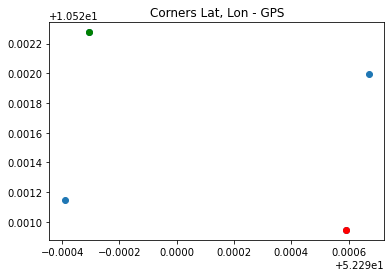

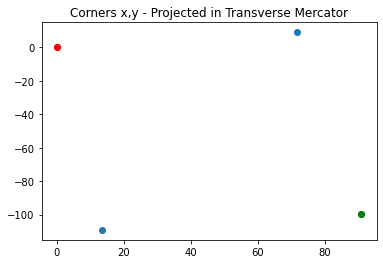

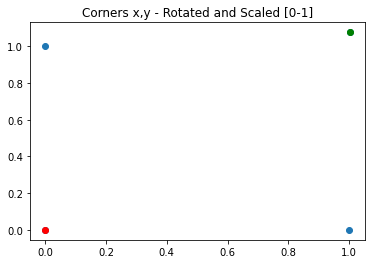

Number of players:  10


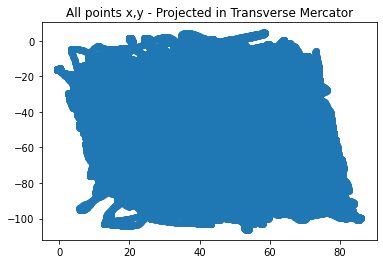

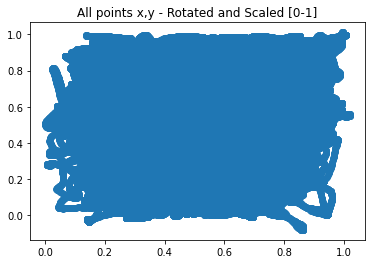

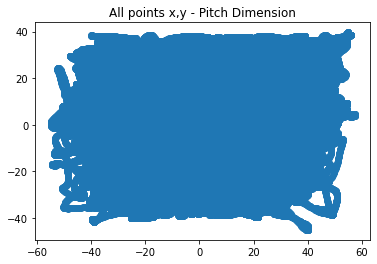

In [11]:
# Select data by rows
df_processed = df_processed.iloc[::skip_rows, :]

# Convert Lat and long (GPS) to Cartisean X,Y
df_main, number_players, x, y = process_location(df_processed, corner_points) 

  ## 10) Heat Maps

  
  #### 10.1) Entire Team

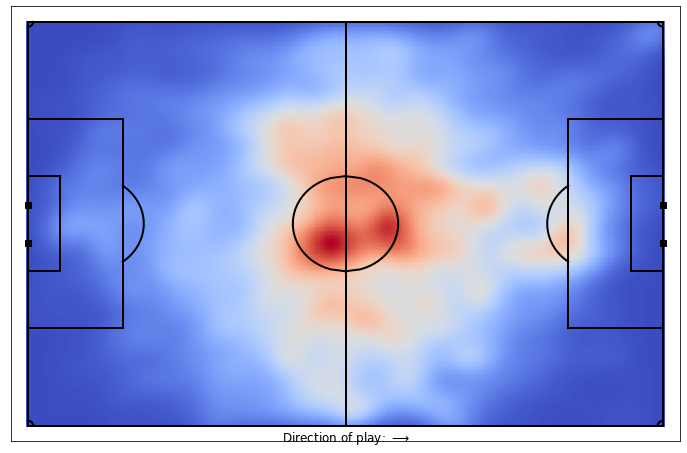

In [12]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300 
x_min = -PITCH_LENGTH/2
x_max = PITCH_LENGTH/2
y_min = -PITCH_WIDTH/2
y_max = PITCH_WIDTH/2

k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Make the plot
fig, ax = plot_pitch() # plot the pitch
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='coolwarm',shading='auto')
plt.show()

   #### 10.2) Per Palyer

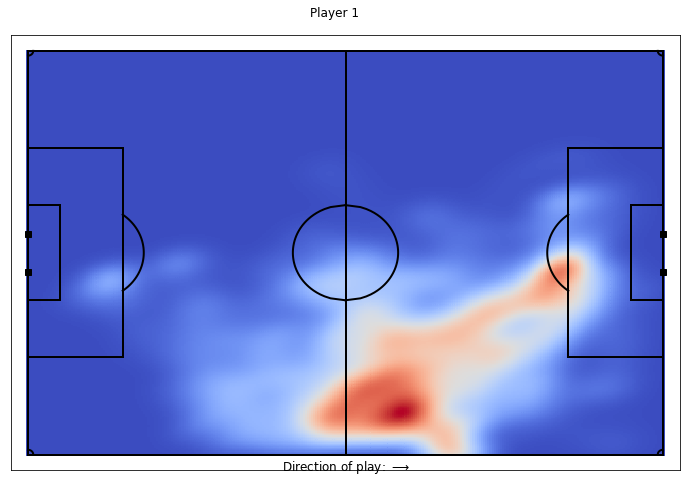

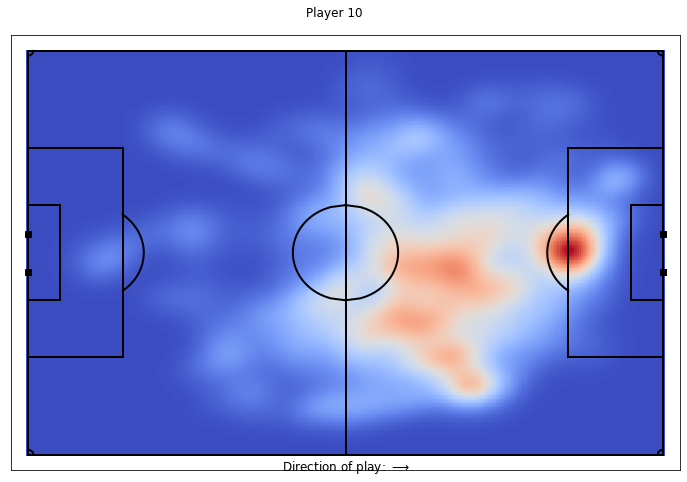

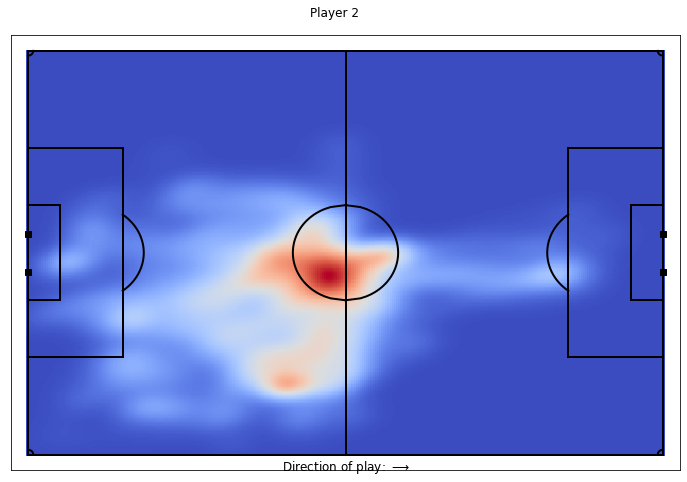

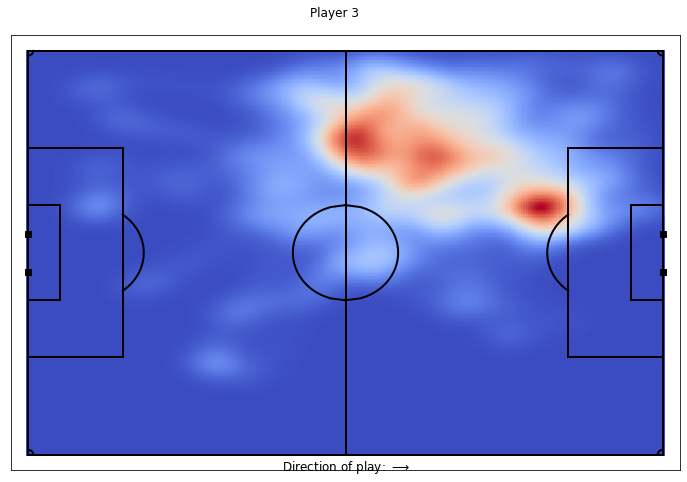

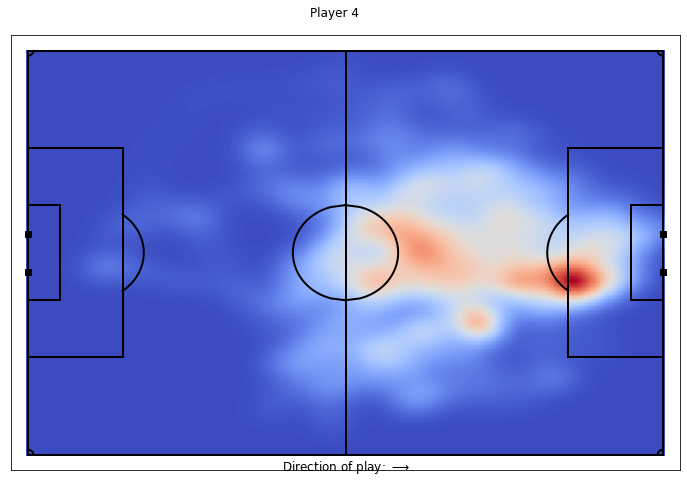

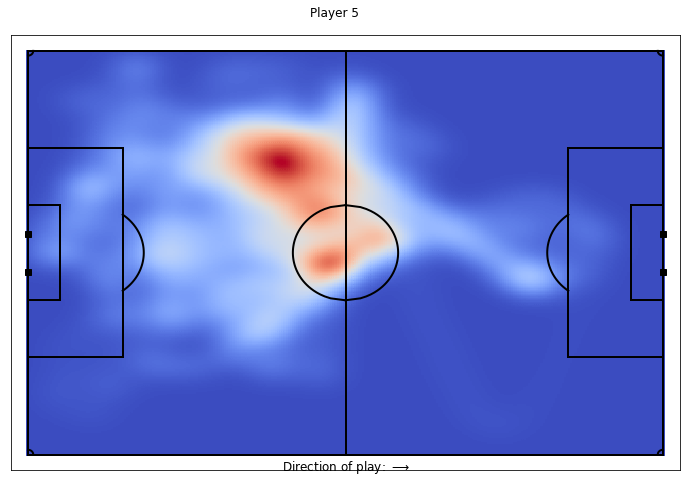

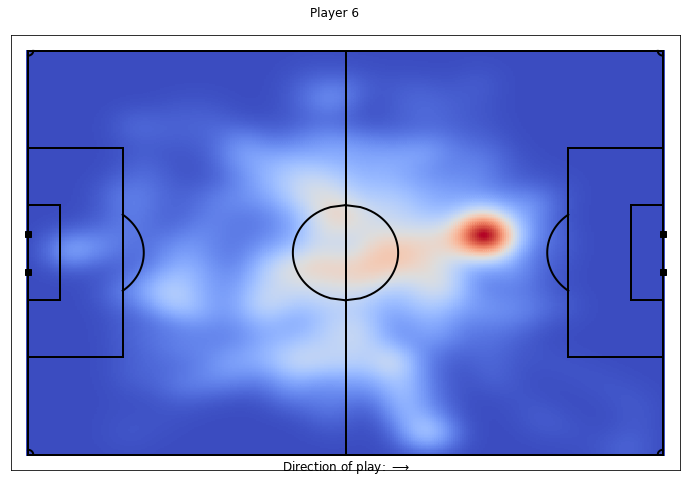

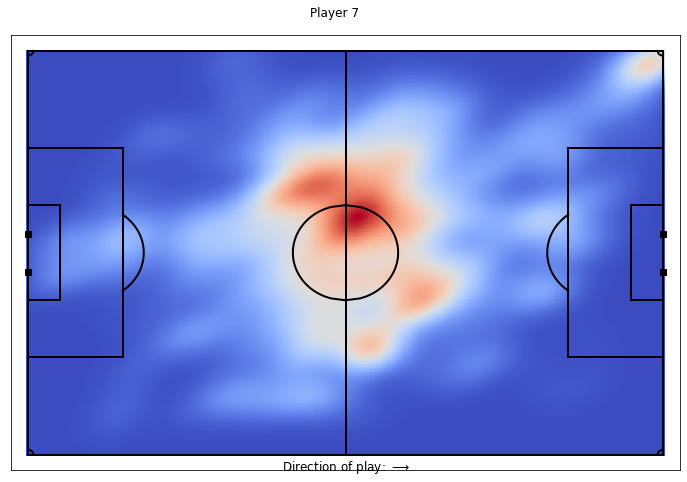

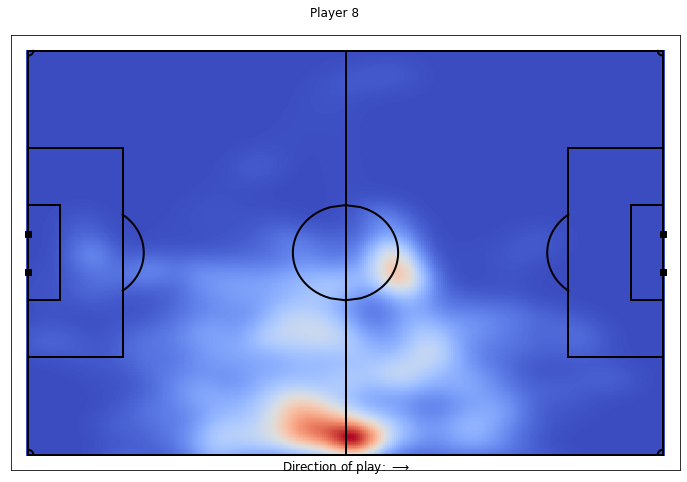

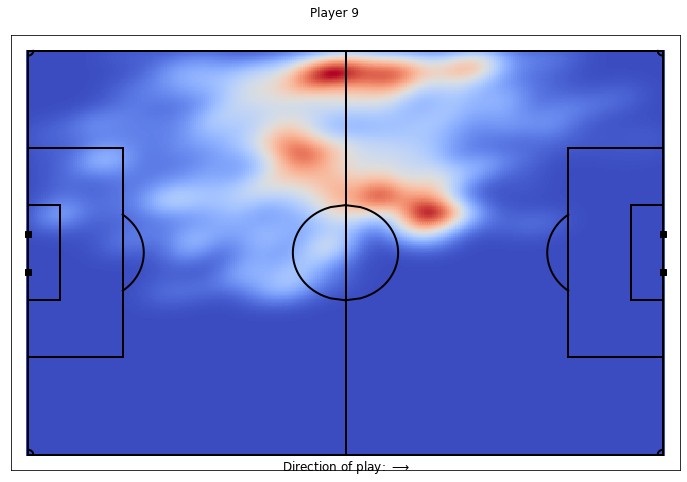

In [13]:
nbins=300
x_min = -PITCH_LENGTH/2
x_max = PITCH_LENGTH/2
y_min = -PITCH_WIDTH/2
y_max = PITCH_WIDTH/2

df_main = df_main.dropna()

for i in range(number_players):
    pl_name = df_main.loc[0, f'Player Display Name_{i}']
    
    x = df_main.loc[:, f'X_{i}']
    y = df_main.loc[:, f'Y_{i}']
    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Make the plot
    fig, ax = plot_pitch()
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='coolwarm', shading='auto')
    plt.suptitle(pl_name, y=0.93)
    plt.show()

## 11) Sprint lines

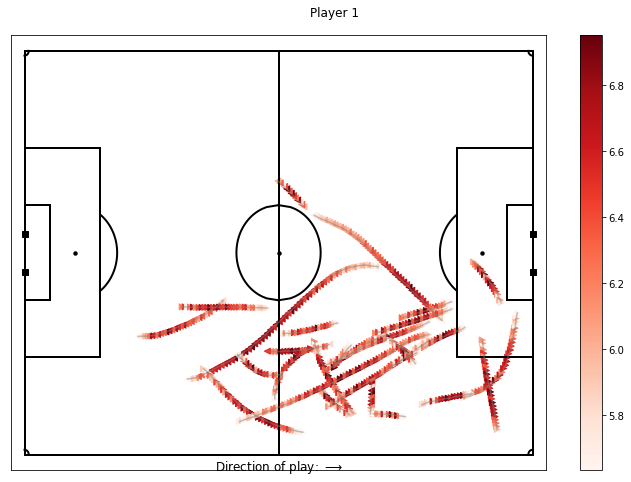

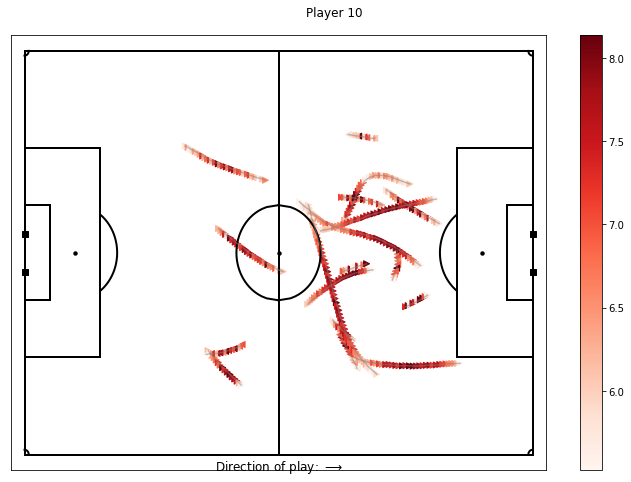

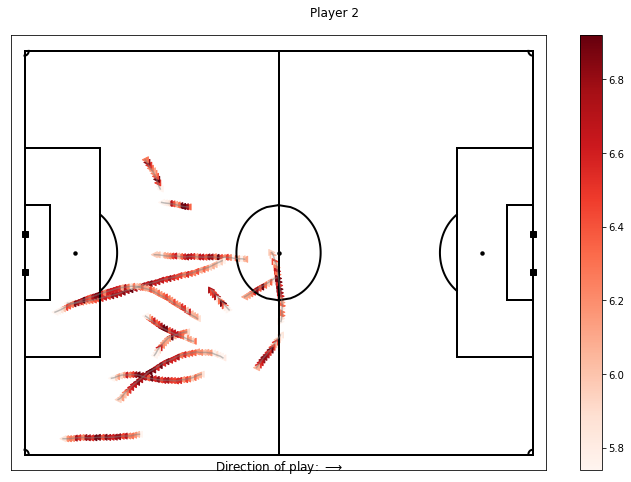

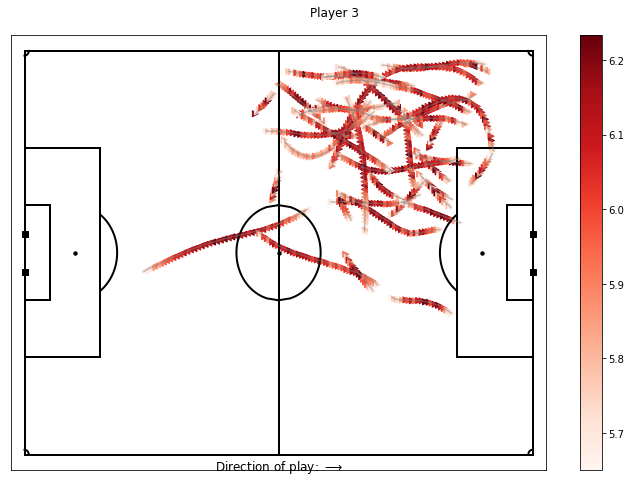

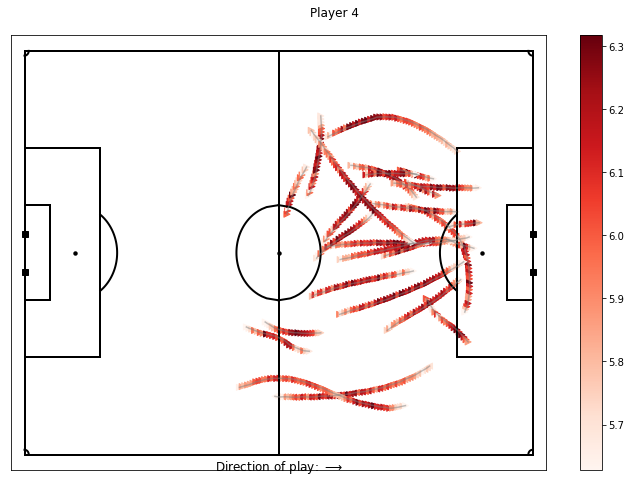

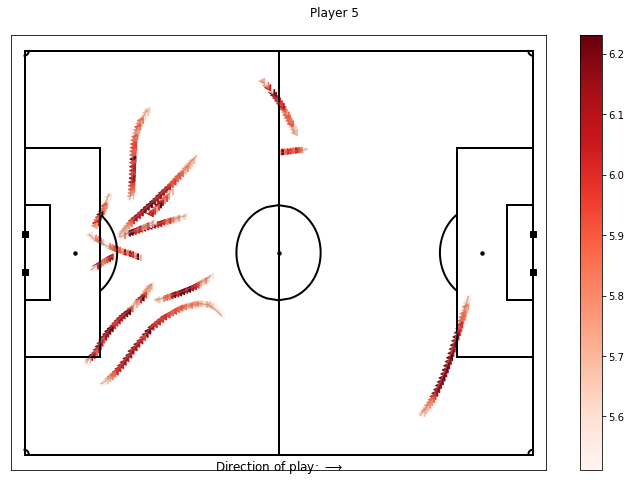

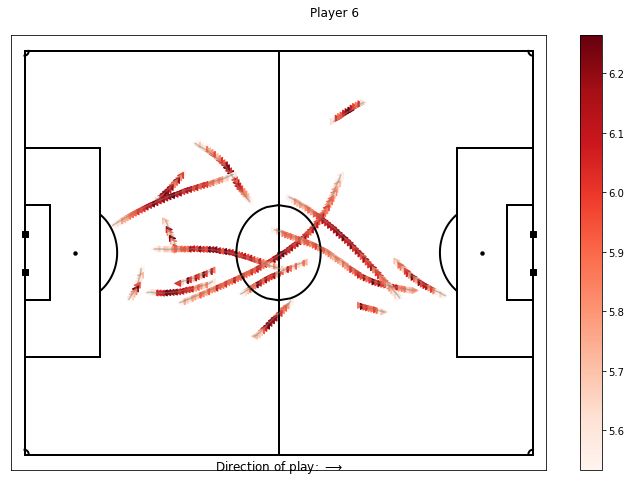

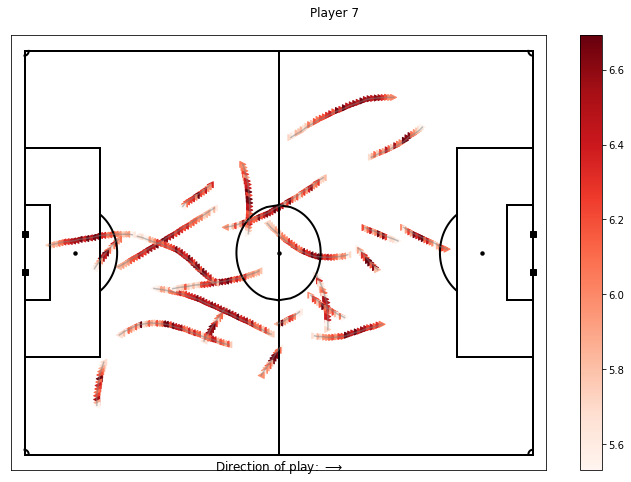

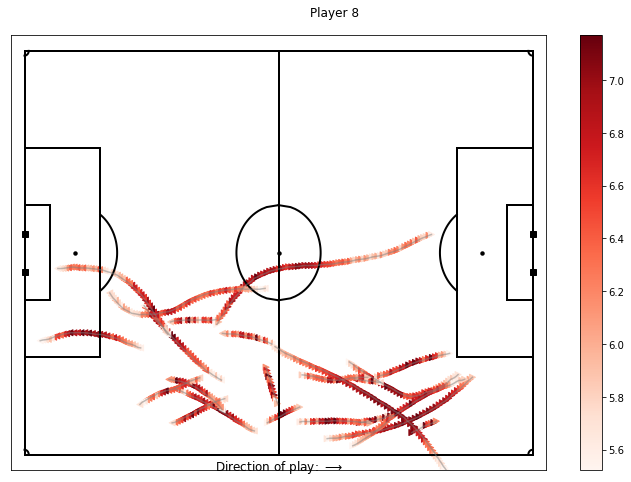

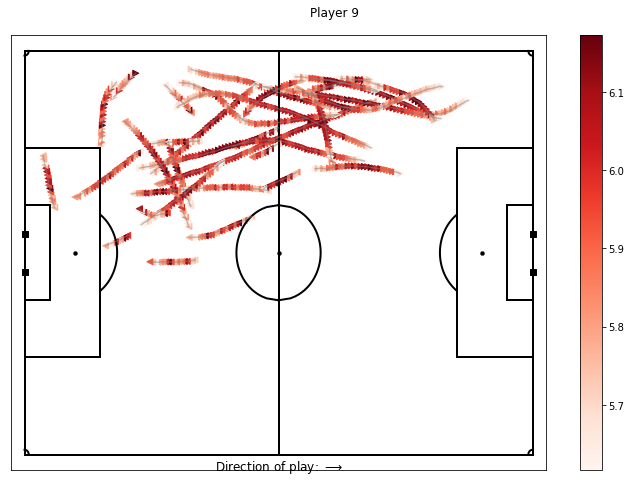

In [14]:
for i in range(number_players):
    pl_name = df_main.loc[0, f'Player Display Name_{i}']
    
    # Sprint Distance (SD): Total distance sustained at a Speed >=sprint_speed  for at least 1sec (DATA_CAPTURE_RATE)
    x_sprint_list, y_sprint_list, v_sprint_list = find_group(df_main[f'Speed (m/s)_{i}'],df_main[f'X_{i}'],df_main[f'Y_{i}'], DATA_CAPTURE_RATE, sprint_speed, 'higher')

    # Make the plot
    fig, ax = plot_pitch()
    
    for j in range(len(x_sprint_list)):
        plt.plot(x_sprint_list[j], y_sprint_list[j], color='grey', linestyle='solid', alpha = 0.5)
        
        # If the horizontal end position is smaller than the initial we assume the player was running back
        if x_sprint_list[j][-1]<x_sprint_list[j][0]:
            plt.scatter(x_sprint_list[j], y_sprint_list[j], c = v_sprint_list[j], marker="<", cmap='Reds')
        else: 
            plt.scatter(x_sprint_list[j], y_sprint_list[j], c = v_sprint_list[j], marker=">", cmap='Reds')
        
    plt.colorbar()    
    plt.suptitle(pl_name, y=0.93)
    plt.show()

## 12) Video and Convex Hull

In [15]:
# Calculate required frames per second to satisfy video time
time_vec = np.round(np.array(df_main.index)/DATA_CAPTURE_RATE/60,2)
fps = np.round((time_vec[-1]/video_time)*DATA_CAPTURE_RATE,0)
print('FPS:', fps)

# Create convex hull and visualizations
hull_list, CM_list, area_list = create_convex_hull(df_main,number_players, fps, x_max, y_max, time_vec)

FPS: 46.0
Generating movie...done


## 13) Plot Area occupied by the team during that half

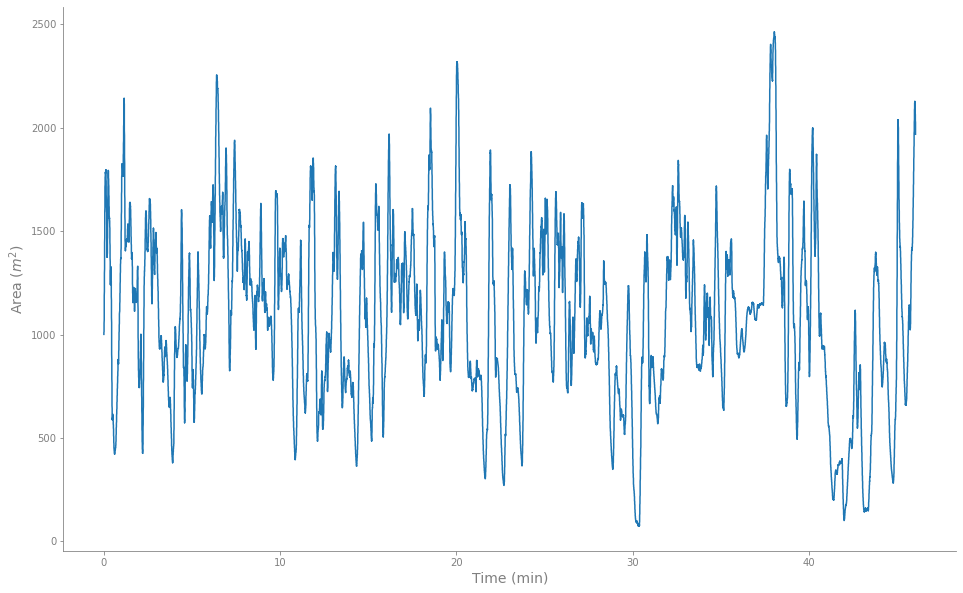

In [16]:
# Plot Area
plt.figure('Area occupied by the team',figsize=(16.0, 10.0))   
plt.plot(time_vec ,area_list)
ax = plt.gca()

# Axis Properties
plt.ylabel('Area ($m^2$)', fontsize=14)
plt.xlabel('Time (min)', fontsize=14)    
# Axis color
ax.spines['bottom'].set_color('grey') 
ax.spines['left'].set_color('grey')
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.yaxis.label.set_color('grey')
ax.xaxis.label.set_color('grey')    
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)      
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()